In [1]:
import pandas as pd
import numpy as np

from data_loader import data_load_and_split

big_firstMeas_train, big_secondMeas_train, big_firstMeas_test, big_secondMeas_test, trimmed_firstMeas_train, trimmed_secondMeas_train, trimmed_firstMeas_test, trimmed_secondMeas_test = data_load_and_split()


/Users/allierose/Library/CloudStorage/OneDrive-DukeUniversity/erdos/Erdos_Trees/machine_learning/data_loader.py:5: DtypeWarning: Columns (86,168,207,211,215) have mixed types. Specify dtype option on import or set low_memory=False.
  def data_load_and_split(big_data=pd.read_csv('../Data/final_big_data.csv'),
/Users/allierose/Library/CloudStorage/OneDrive-DukeUniversity/erdos/Erdos_Trees/machine_learning/data_loader.py:6: DtypeWarning: Columns (55,59,63) have mixed types. Specify dtype option on import or set low_memory=False.
  trimmed_data= pd.read_csv('../Data/trimmed_data.csv'),


In [2]:
from data_loader import data_merge

combined_train =data_merge(trimmed_firstMeas_train, trimmed_secondMeas_train)

SPCD inconsistent; column will not be merged.
SPGRPCD inconsistent; column will not be merged.
 STATUSCD_post_burn
2    5377
1    2066
3     313
0     180
Name: count, dtype: int64 
0 = couldn't resample, 1 = alive, 2 = dead, 3 = removed by humans


## On to the data science!

In [3]:
combined_train.info()
combined_train[["ELEV", "BURN_AREA_TOTAL","DIA_pre_burn","HT_pre_burn","DRYBIO_AG_pre_burn","NUM_BURNS","CULL_pre_burn","STATUSCD_post_burn"]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 7443 entries, 0 to 9724
Columns: 102 entries, PLOT to ALIVE_post_burn
dtypes: float64(66), int64(28), object(8)
memory usage: 5.8+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 7443 entries, 0 to 9724
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ELEV                7443 non-null   float64
 1   BURN_AREA_TOTAL     7443 non-null   float64
 2   DIA_pre_burn        7443 non-null   float64
 3   HT_pre_burn         7443 non-null   float64
 4   DRYBIO_AG_pre_burn  7443 non-null   float64
 5   NUM_BURNS           7443 non-null   int64  
 6   CULL_pre_burn       6751 non-null   float64
 7   STATUSCD_post_burn  7443 non-null   int64  
dtypes: float64(6), int64(2)
memory usage: 523.3 KB


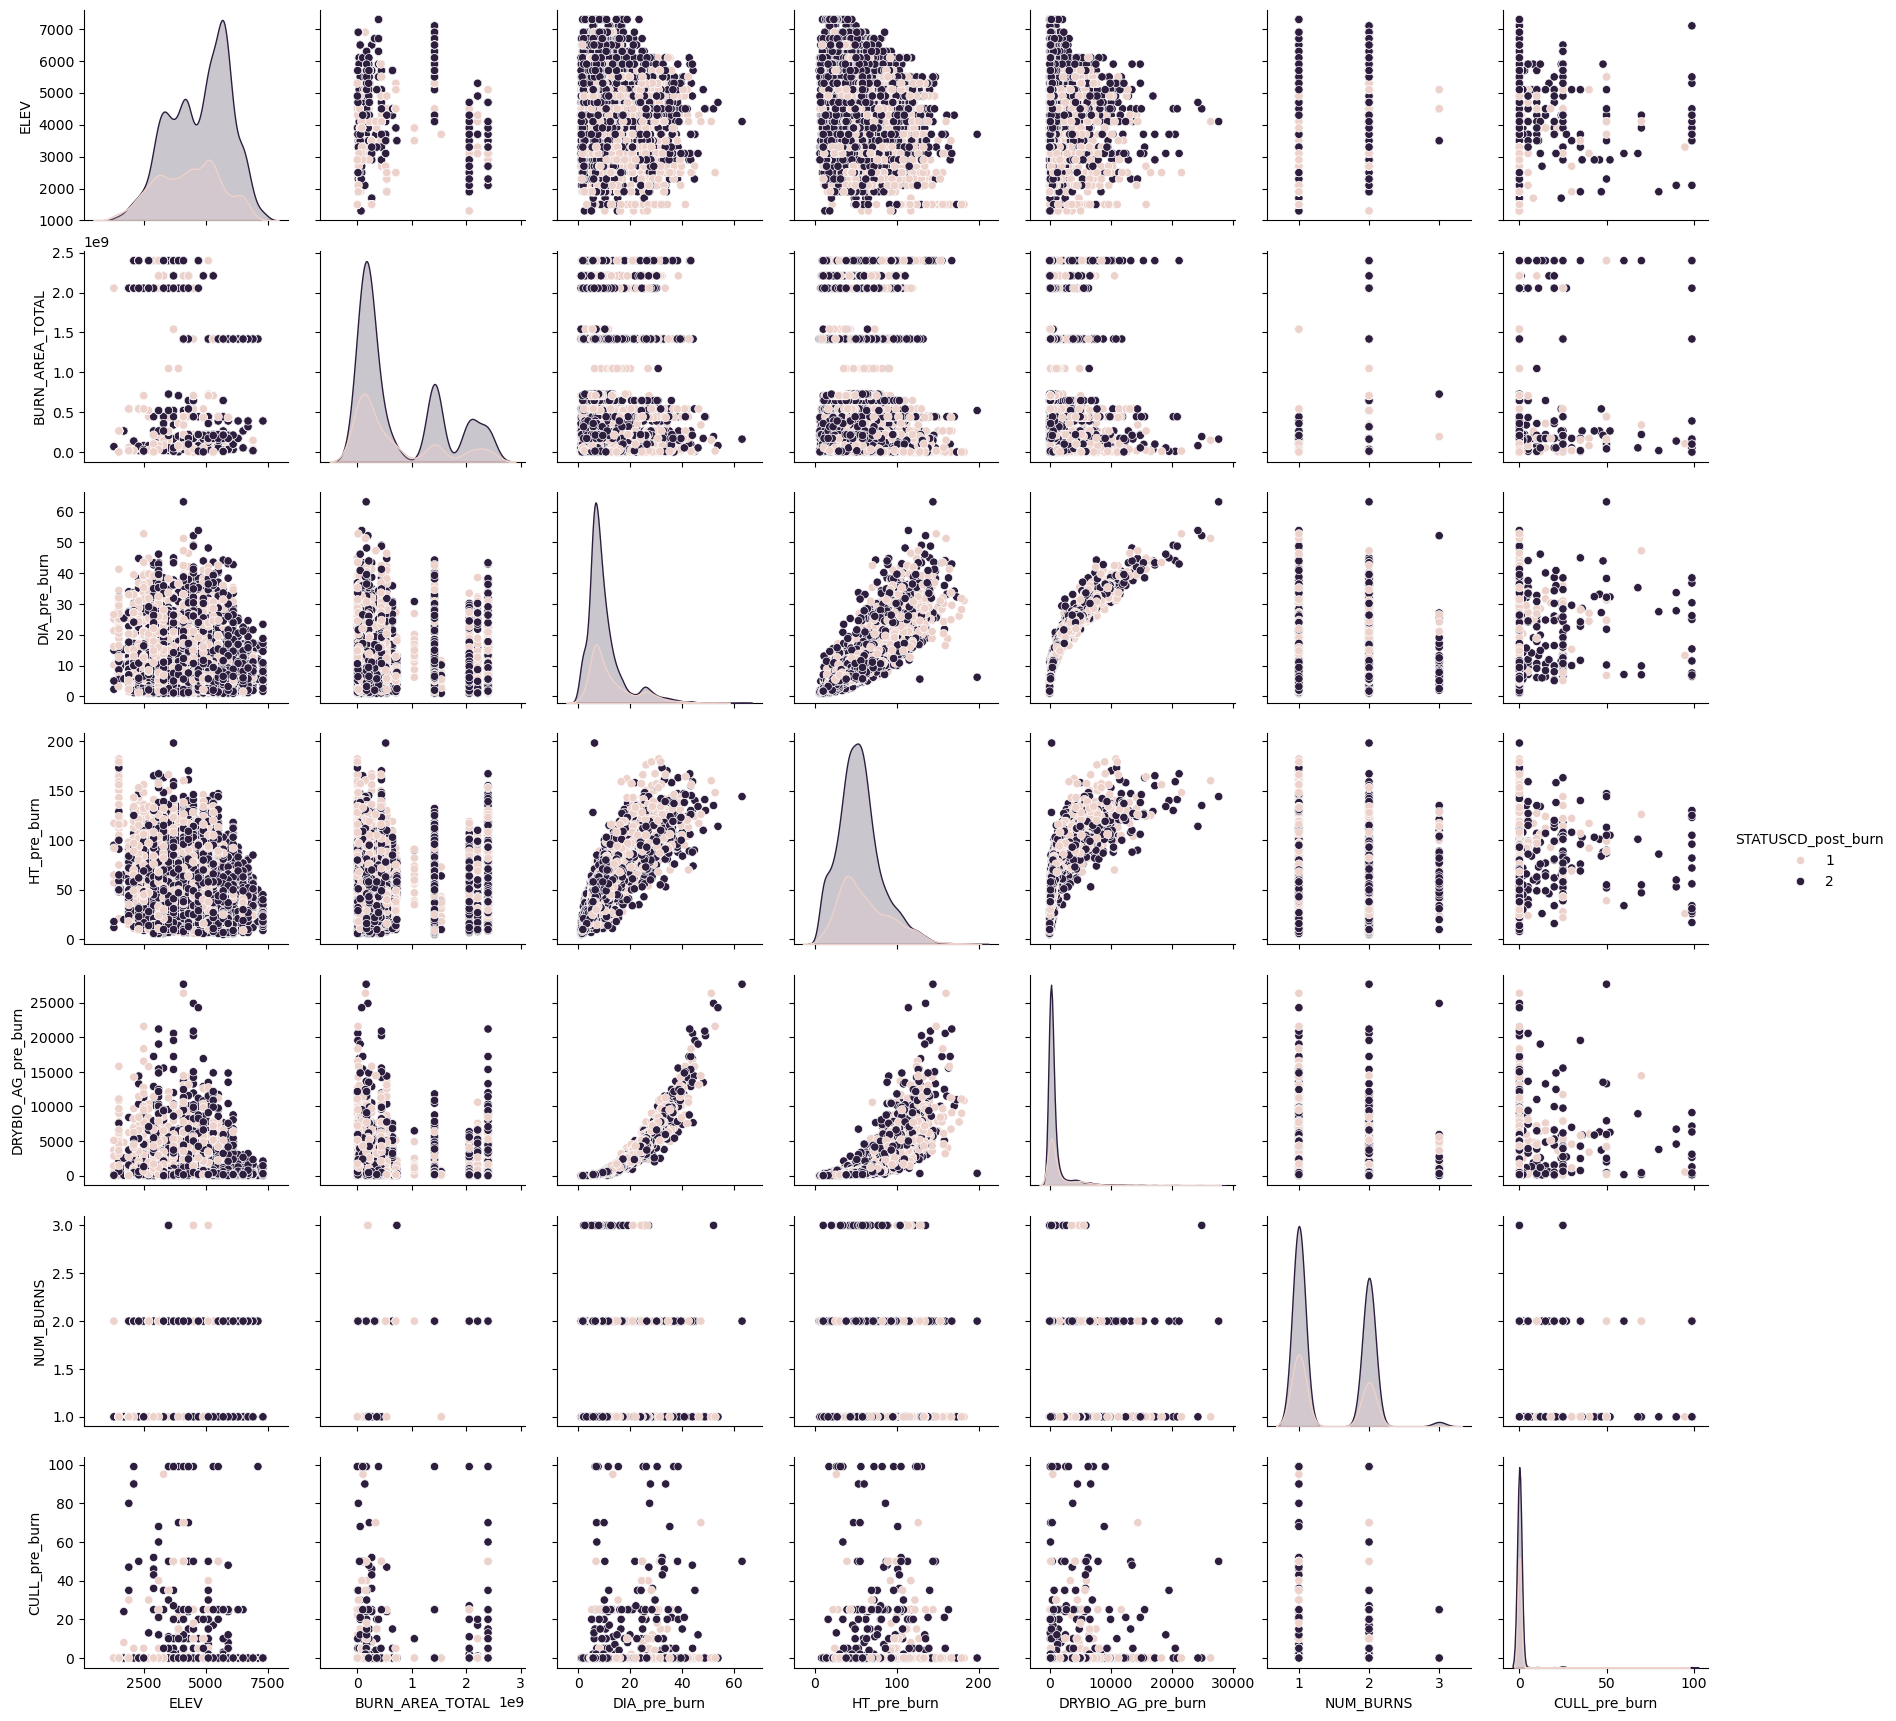

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.pairplot(combined_train[["ELEV", "BURN_AREA_TOTAL","DIA_pre_burn","HT_pre_burn","DRYBIO_AG_pre_burn","NUM_BURNS","CULL_pre_burn","STATUSCD_post_burn"]],hue="STATUSCD_post_burn")

Based on these plots, we could maybe do some classification methods using diameter, height, cull damage, number of fires, and area of burn However, diameter, height, and dry bio age look to be highly correlated, so let's only use one. Also, it looks like a linear decision line could be drawn between height/diameter and elevation nicely. 

In [3]:
# Let's not do Cull for now as there are some nan values
indicator_features = ["ELEV","HT_pre_burn","BURN_AREA_TOTAL"]

**SVC**

In [4]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
import scipy.stats


In [5]:
n_splits = 5

## Make the kfold object
kfold = StratifiedKFold(n_splits, 
                        random_state=218, 
                        shuffle=True)

dummy_clf = DummyClassifier(strategy='stratified', random_state=218)
DummyAccuracies = np.zeros((n_splits, 1))
for i,(train_index, test_index) in enumerate(kfold.split(combined_train[indicator_features],combined_train['STATUSCD_post_burn'])):
    trees_tt = combined_train.iloc[train_index]
    trees_ho = combined_train.iloc[test_index]
        
        
    dummy_clf.fit(trees_tt[indicator_features],trees_tt[['STATUSCD_post_burn']])
    dummy_pred = dummy_clf.predict(trees_ho[indicator_features])
    DummyAccuracies[i] = accuracy_score(trees_ho['STATUSCD_post_burn'], dummy_pred)


In [9]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaling step
    ('svc', SVC())  # Classifier step
])
param_grid = {
    'svc__C': [0.1,1,10,50],
    'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#    'svc__degree': [2, 3],  # Applies only to 'poly'
#    'svc__gamma': ['scale', 'auto']  # Applies to 'rbf' and 'sigmoid'
}
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=kfold,  
    verbose=2, 
)
grid_search.fit(combined_train[indicator_features], combined_train['STATUSCD_post_burn'].values)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .....................svc__C=0.1, svc__kernel=linear; total time=   0.4s
[CV] END .....................svc__C=0.1, svc__kernel=linear; total time=   0.4s
[CV] END .....................svc__C=0.1, svc__kernel=linear; total time=   0.4s
[CV] END .....................svc__C=0.1, svc__kernel=linear; total time=   0.4s
[CV] END .....................svc__C=0.1, svc__kernel=linear; total time=   0.4s
[CV] END .......................svc__C=0.1, svc__kernel=poly; total time=   0.9s
[CV] END .......................svc__C=0.1, svc__kernel=poly; total time=   0.8s
[CV] END .......................svc__C=0.1, svc__kernel=poly; total time=   0.8s
[CV] END .......................svc__C=0.1, svc__kernel=poly; total time=   0.8s
[CV] END .......................svc__C=0.1, svc__kernel=poly; total time=   0.8s
[CV] END ........................svc__C=0.1, svc__kernel=rbf; total time=   1.1s
[CV] END ........................svc__C=0.1, svc

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=218, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [0.1, 1, 10, 50],
                         'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy', verbose=2)

In [17]:
# Find optimal parameters 
cv_results = pd.DataFrame(grid_search.cv_results_)
best_kernel = grid_search.best_params_['svc__kernel']
best_index = grid_search.best_index_  # Index of the best parameter set
print(cv_results.iloc[best_index])   # Full details of the best set


mean_fit_time                                    1.249244
std_fit_time                                     0.064895
mean_score_time                                  0.386761
std_score_time                                   0.001624
param_svc__C                                         50.0
param_svc__kernel                                     rbf
params               {'svc__C': 50, 'svc__kernel': 'rbf'}
split0_test_score                                0.767629
split1_test_score                                0.764271
split2_test_score                                0.752183
split3_test_score                                    0.75
split4_test_score                                0.751344
mean_test_score                                  0.757085
std_test_score                                   0.007349
rank_test_score                                         1
Name: 14, dtype: object


In [8]:
print(f"Accuracy of Dummy Classifier with Stratified Strategy: {np.mean(DummyAccuracies):.2f}")

Accuracy of Dummy Classifier with Stratified Strategy: 0.61


Even though SVC outdid the baseline (75.2% compared to 61%), the C value that fit best was 50 which was max C value for it, so let's look into this more. 

In [21]:
n_splits = 5

## Make the kfold object
kfold = StratifiedKFold(n_splits, 
                        random_state=218, 
                        shuffle=True)

Cvalues = [50,70,80,100]
C_accuracies_rbf = np.zeros((n_splits, len(Cvalues)))




for i,(train_index, test_index) in enumerate(kfold.split(combined_train[indicator_features],combined_train['STATUSCD_post_burn'])):
    trees_tt = combined_train.iloc[train_index]
    trees_ho = combined_train.iloc[test_index]
    for j,C in enumerate(Cvalues):
        pipe_rbf = Pipeline([('scale', StandardScaler()),
                            ('svm', SVC(C=C))])

        
        pipe_rbf.fit(trees_tt[indicator_features],
                    trees_tt['STATUSCD_post_burn'])

        
        pred_rbf = pipe_rbf.predict(trees_ho[indicator_features])


        C_accuracies_rbf[i, j] = accuracy_score(trees_ho['STATUSCD_post_burn'], pred_rbf)


In [24]:
mean_cv_accuracy = np.mean(C_accuracies_rbf, axis=0)
optimal_index = np.argmax(mean_cv_accuracy)
optimal_C = Cvalues[optimal_index]
optimal_accuracy = mean_cv_accuracy[optimal_index]

print(f"The optimal C was {optimal_C} which gave a mean CV accuracy of {optimal_accuracy:.3f}")

The optimal C was 70 which gave a mean CV accuracy of 0.758
[[0.76762928 0.76561451 0.7662861  0.7662861 ]
 [0.76427132 0.76359973 0.76359973 0.76427132]
 [0.75218267 0.75486904 0.75419745 0.75419745]
 [0.75       0.75       0.74798387 0.7452957 ]
 [0.75134409 0.75403226 0.75403226 0.75403226]]


Seems that C= 70 gives the best accuracy score